In [1]:
import pandas as pd
import numpy as np
import alphalens as al
import pymysql

import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus']=False


from scipy.stats.mstats import winsorize


from sklearn.linear_model import LinearRegression

import statsmodels.formula.api as sm



In [5]:
conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select ts_code,trade_date,close,total_share from stock_basic'
daily_sheet=pd.read_sql(sql,conn)

sql='select ts_code,ticker,act_pubtime,publish_date,end_date,n_income,noperate_income,noperate_exp from stock_income'
income_sheet=pd.read_sql(sql,conn)

In [7]:
income_sheet_use

ts_code   end_date  ticker         act_pubtime publish_date  \
0       000001.SZ 2007-03-31  000001 2007-04-25 18:00:00   2007-04-26   
2       000001.SZ 2007-06-30  000001 2007-08-15 18:00:00   2007-08-16   
4       000001.SZ 2007-09-30  000001 2007-10-22 18:00:00   2007-10-23   
8       000001.SZ 2007-12-31  000001 2008-03-19 18:00:00   2008-03-20   
10      000001.SZ 2008-03-31  000001 2008-04-23 18:00:00   2008-04-24   
...           ...        ...     ...                 ...          ...   
834021  900957.SH 2020-09-30  900957 2020-10-28 15:44:36   2020-10-29   
834026  900957.SH 2020-12-31  900957 2021-04-08 18:13:16   2021-04-09   
834028  900957.SH 2021-03-31  900957 2021-04-26 16:30:45   2021-04-27   
834030  900957.SH 2021-06-30  900957 2021-08-11 16:03:10   2021-08-12   
834032  900957.SH 2021-09-30  900957 2021-10-28 15:35:42   2021-10-29   

            n_income  noperate_income  noperate_exp  
0       5.350840e+08        3302280.0      582457.0  
2       1.123980e+09       26843000.0    18694000.0  
4       7.496340e+08        1533000.0     3119000.0  
8       2.649900e+09       89720000.0    39887000.0  
10      1.004180e+09        4545000.0     1791000.0  
...              ...              ...           ...  
834021  5.727600e+06              NaN           NaN  
834026  2.185870e+07        1012300.0       60635.4  
834028  8.365930e+06              NaN           NaN  
834030  1.491380e+07              NaN           NaN  
834032  2.097630e+07              NaN           NaN  

[181329 rows x 8 columns]

In [8]:


daily_sheet["trade_date"] = pd.to_datetime(daily_sheet["trade_date"])


income_sheet["act_pubtime"] = pd.to_datetime(income_sheet["act_pubtime"])
income_sheet["publish_date"] = pd.to_datetime(income_sheet["publish_date"])
income_sheet["end_date"] = pd.to_datetime(income_sheet["end_date"])

income_sheet=income_sheet.sort_values(by=['ts_code','end_date'])
income_sheet=income_sheet.set_index(["ts_code","end_date"]).reset_index()
daily_sheet=daily_sheet.sort_values(by=['ts_code','trade_date'])
daily_sheet=daily_sheet.set_index(["ts_code","trade_date"]).reset_index()

income_sheet_use=income_sheet.drop_duplicates(subset=['end_date','ts_code'],keep='first')

income_sheet_use["nonrecurrent_gains/losses"]=income_sheet_use["noperate_income"]-income_sheet_use["noperate_exp"]
income_sheet_use["rev_without_nocur_gain"]=income_sheet_use["n_income"]-income_sheet_use["nonrecurrent_gains/losses"]
income_sheet_1=income_sheet_use[['ts_code','publish_date','end_date','rev_without_nocur_gain']]

daily_sheet["market_equity"]=daily_sheet["total_share"]*daily_sheet["close"]

income_sheet_2=income_sheet_1.rename(columns={'publish_date':'trade_date'})

merge_T=pd.merge(income_sheet_2,daily_sheet,on=['ts_code','trade_date'],how='outer')
merge_T=merge_T.sort_values(by=['ts_code','trade_date'])
merge_T1=merge_T.set_index(['trade_date','ts_code'])
merge_T1=merge_T1.reset_index()
merge_T2=merge_T1.drop_duplicates(subset=['trade_date','ts_code'],keep='last')
merge_T3=merge_T2.set_index(['trade_date','ts_code'])

merge_T_FILL=merge_T3['rev_without_nocur_gain'].unstack()

merge_T_FILL=merge_T_FILL.fillna(method='ffill')
merge_T4=merge_T_FILL.stack().reset_index()
merge_T4=merge_T4.rename(columns={0:'rev_without_nocur_gain'})

final=pd.merge(merge_T4,daily_sheet,on=['trade_date','ts_code'],how='right')
final["ep"]=final["rev_without_nocur_gain"]/final["market_equity"]
final=final.sort_values(by=['ts_code','trade_date'])
final=final.set_index(["ts_code","trade_date"]).reset_index()
# final["Zscore_winso"]=winsorize(final.Zscore,limits=[0.01,0.01])

final_1=final.set_index(['trade_date','ts_code'])
final_2=final_1['ep'].unstack()
final_3=final_2.shift(252)
final_4=final_3.stack().reset_index()
final_4=final_4.rename(columns={0:'EP'})

final_5=pd.merge(final_4,daily_sheet,on=['trade_date','ts_code'],how='right')
final_5=final_5.sort_values(by=['ts_code','trade_date'])
final_5=final_5.set_index(["ts_code","trade_date"]).reset_index()

<ipython-input-8-04532280b577>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_sheet_use["nonrecurrent_gains/losses"]=income_sheet_use["noperate_income"]-income_sheet_use["noperate_exp"]
<ipython-input-8-04532280b577>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  income_sheet_use["rev_without_nocur_gain"]=income_sheet_use["n_income"]-income_sheet_use["nonrecurrent_gains/losses"]


In [20]:
final_5=final_5.dropna()

In [9]:
##获取行业代码数据

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select ts_code,trade_date,industry_id from stock_industry'
industry_sheet=pd.read_sql(sql,conn)


# 获取行业ID与行业名称

conn=pymysql.connect(host='10.3.71.120',database='quant',user='root',password='stark12345+',port=3306)
sql='select industry_id,industry_name from sw_industry'
industry_name_sheet=pd.read_sql(sql,conn)

In [10]:
# data_use=data_use.set_index(["trade_date","ts_code"]).reset_index()
# data_use=data_use.sort_values(by=['ts_code','trade_date'])
# data_use["trade_date"] = pd.to_datetime(data_use["trade_date"])

industry_use=industry_sheet.set_index(["trade_date","ts_code"]).reset_index()
industry_use=industry_use.sort_values(by=['ts_code','trade_date'])
industry_use["trade_date"] = pd.to_datetime(industry_use["trade_date"])

industry_use_1=pd.merge(industry_use,industry_name_sheet,on=['industry_id'],how='left')

In [52]:


industry_factor=pd.merge(industry_use_1,final_5,on=['ts_code','trade_date'],how='inner')
industry_factor=pd.merge(industry_factor,daily_sheet,on=['ts_code','trade_date','close','total_share','market_equity'])
industry_factor_1=industry_factor[industry_factor['trade_date']=='2020-12-31']
industry_factor_2=industry_factor_1.groupby(['industry_name'])['EP'].mean()
industry_factor_2=pd.DataFrame(industry_factor_2)
industry_factor_2=industry_factor_2.reset_index()

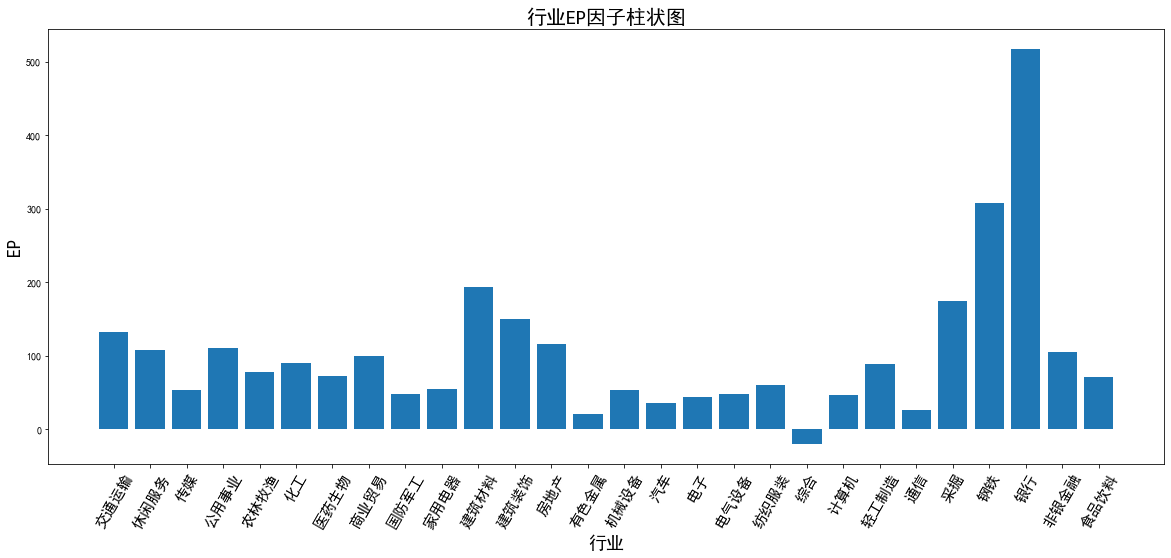

<Figure size 432x288 with 0 Axes>

In [136]:
####行业换手率因子柱状图 (数据采纳2020.12.31各行业均值)

plt.figure(figsize=(20,8))
x=industry_factor_2['industry_name']
y=industry_factor_2['EP']
plt.bar(x,y)
plt.title('行业EP因子柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(0,6,1)
plt.xlabel('行业',fontsize=18)
plt.ylabel('EP',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('行业EP因子柱状图.png')

In [137]:
# 行业因子排名表格，数据：2015-2020年最后一个交易日数据行业均值

industry_rank=industry_factor[(industry_factor['trade_date']=='2020-12-31')|(industry_factor['trade_date']=='2019-12-31')|(industry_factor['trade_date']=='2018-12-28')|(industry_factor['trade_date']=='2017-12-29')|(industry_factor['trade_date']=='2016-12-30')|(industry_factor['trade_date']=='2015-12-31')]
industry_rank_1=industry_rank.groupby(['trade_date','industry_name'])['EP'].mean()
industry_rank_2=pd.DataFrame(industry_rank_1).reset_index()
industry_rank_2['年份']=industry_rank_2['trade_date'].dt.year
industry_rank_2=industry_rank_2.rename(columns={'industry_name':'行业'})
industry_rank_2['rank']=industry_rank_2.groupby(['年份'])['EP'].rank(ascending=False)
industry_rank_3=industry_rank_2.set_index(['行业','年份'])['rank'].unstack()
file='行业EP因子排名.xlsx'
industry_rank_3.to_excel(file)

In [138]:
industry_rank_3

年份    2015  2016  2017  2018  2019  2020
行业                                      
交通运输   5.0   4.0   4.0   3.0   5.0   6.0
休闲服务   6.0   6.0   7.0   9.0   6.0   9.0
传媒    16.0  14.0  17.0  15.0  20.0  20.0
公用事业   3.0   3.0   3.0   8.0  15.0   8.0
农林牧渔  21.0  21.0  18.0  24.0  11.0  14.0
化工    20.0  18.0  22.0  18.0  10.0  12.0
医药生物  11.0   8.0  12.0  11.0  13.0  15.0
商业贸易  13.0  19.0  23.0  19.0   7.0  11.0
国防军工  27.0  25.0  26.0  28.0  28.0  21.0
家用电器   7.0   9.0   8.0  21.0  27.0  18.0
建筑材料  14.0  24.0   6.0   6.0   4.0   3.0
建筑装饰   4.0   5.0   5.0   5.0   8.0   5.0
房地产    8.0  15.0  10.0   7.0   9.0   7.0
有色金属  23.0  26.0  21.0  12.0  23.0  27.0
机械设备  22.0  22.0  27.0  22.0  21.0  19.0
汽车     9.0  11.0  13.0  13.0  19.0  25.0
电子    17.0  12.0  20.0  17.0  24.0  24.0
电气设备  15.0  13.0  19.0  20.0  25.0  22.0
纺织服装  10.0  10.0  16.0  14.0  16.0  17.0
综合    24.0  20.0  14.0  27.0  18.0  28.0
计算机   26.0  23.0  25.0  26.0  26.0  23.0
轻工制造  19.0  17.0  15.0  10.0  12.0  13.0
通信    25.0  16.0  24.0  25.0  22.0  26.0
采掘    18.0  27.0  28.0  23.0   3.0   4.0
钢铁    28.0  28.0   9.0   2.0   2.0   2.0
银行     1.0   1.0   1.0   1.0   1.0   1.0
非银金融   2.0   2.0   2.0   4.0  14.0  10.0
食品饮料  12.0   7.0  11.0  16.0  17.0  16.0

In [56]:
industry_factor

trade_date    ts_code industry_id industry_name          EP  close  \
0       2008-05-12  000001.SZ      005013          金融服务  105.430998  26.85   
1       2008-05-15  000001.SZ      005013          金融服务  100.401263  27.18   
2       2008-05-16  000001.SZ      005013          金融服务   99.815192  27.75   
3       2008-05-19  000001.SZ      005013          金融服务  102.087105  28.00   
4       2008-05-20  000001.SZ      005013          金融服务   98.238219  26.18   
...            ...        ...         ...           ...         ...    ...   
7577759 2022-03-22  689009.SH      011024          机械设备  171.304672  46.30   
7577760 2022-03-23  689009.SH      011024          机械设备  182.850807  46.21   
7577761 2022-03-25  689009.SH      011024          机械设备  178.005549  45.23   
7577762 2022-03-28  689009.SH      011024          机械设备  174.132877  45.00   
7577763 2022-03-29  689009.SH      011024          机械设备  182.555027  45.11   

         total_share  market_equity  
0        229340.7145   6.157798e+06  
1        229340.7145   6.233481e+06  
2        229340.7145   6.364205e+06  
3        229340.7145   6.421540e+06  
4        229340.7145   6.004140e+06  
...              ...            ...  
7577759   70788.7210   3.277518e+06  
7577760   70788.7210   3.271147e+06  
7577761   70788.7210   3.201774e+06  
7577762   70788.7210   3.185492e+06  
7577763   70788.7210   3.193279e+06  

[7577764 rows x 8 columns]

In [57]:
# 因子按市值分层：1-5递增  数据为2015-2020年最后一个交易日数据

industry_factor['firm_size']=industry_factor['total_share']*industry_factor['close']
firm_size_group=industry_factor[(industry_factor['trade_date']=='2020-12-31')|(industry_factor['trade_date']=='2019-12-31')|(industry_factor['trade_date']=='2018-12-28')|(industry_factor['trade_date']=='2017-12-29')|(industry_factor['trade_date']=='2016-12-30')|(industry_factor['trade_date']=='2015-12-31')]
firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))
firm_size_group_1=pd.DataFrame(firm_size_group.groupby(['trade_date','Group_ID'])['EP'].mean()).reset_index()
firm_size_group_1['year']=firm_size_group_1['trade_date'].dt.year

<ipython-input-57-05dfa1e7a494>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  firm_size_group['Group_ID']=firm_size_group.groupby(['trade_date'])['firm_size'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))


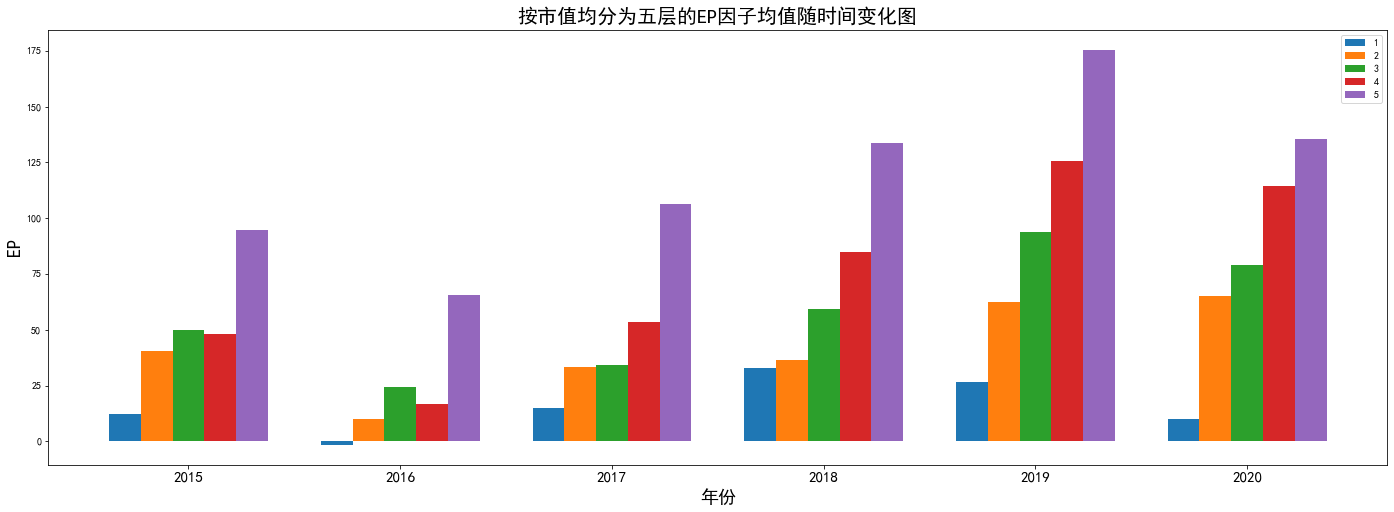

<Figure size 432x288 with 0 Axes>

In [139]:
# 按市值均分为五层的因子均值随时间变化图 数据为2015-2020年最后一个交易日数据

x=pd.Series(np.unique(firm_size_group_1['year']))
labels=['2015','2016','2017','2018','2019','2020']


y1=firm_size_group_1[firm_size_group_1['Group_ID']=='1'].EP
y2=firm_size_group_1[firm_size_group_1['Group_ID']=='2'].EP
y3=firm_size_group_1[firm_size_group_1['Group_ID']=='3'].EP
y4=firm_size_group_1[firm_size_group_1['Group_ID']=='4'].EP
y5=firm_size_group_1[firm_size_group_1['Group_ID']=='5'].EP

width=0.15
pos=np.arange(len(x))

plt.figure(figsize=(24,8))
plt.bar(pos-2*width,y1,width,label='1')
plt.bar(pos-1*width,y2,width,label='2')
plt.bar(pos,y3,width,label='3')
plt.bar(pos+1*width,y4,width,label='4')
plt.bar(pos+2*width,y5,width,label='5')
# plt.grid()
plt.legend() # 图例
plt.title('按市值均分为五层的EP因子均值随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(pos,labels=labels,fontsize=15)
# plt.yticks(y,fontsize=15)
# # plt.ylim(0,6,1)
plt.xlabel('年份',fontsize=18)
plt.ylabel('EP',fontsize=18)

plt.show()
plt.savefig('按市值均分为五层的EP因子均值随时间变化图.png')

In [59]:
# 因子与市值的相关系数变化:不分股票，一年所有数据进行corr计算 2015-2020

industry_factor['year']=industry_factor['trade_date'].dt.year
corr=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
corr_1=pd.DataFrame(corr.groupby(['year'])['EP'].corr(corr['firm_size'])).reset_index()
corr_1=corr_1.rename(columns={'EP':'corr'})

# 因子与市值的相关系数变化:不分股票，一个交易日所有数据进行corr计算
corr_2=pd.DataFrame(corr.groupby(['trade_date'])['EP'].corr(corr['firm_size'])).reset_index()
corr_2=corr_2.rename(columns={'EP':'corr'})

In [60]:
corr_1

year      corr
0  2015  0.202601
1  2016  0.261090
2  2017  0.240514
3  2018  0.223544
4  2019  0.120398
5  2020  0.094230

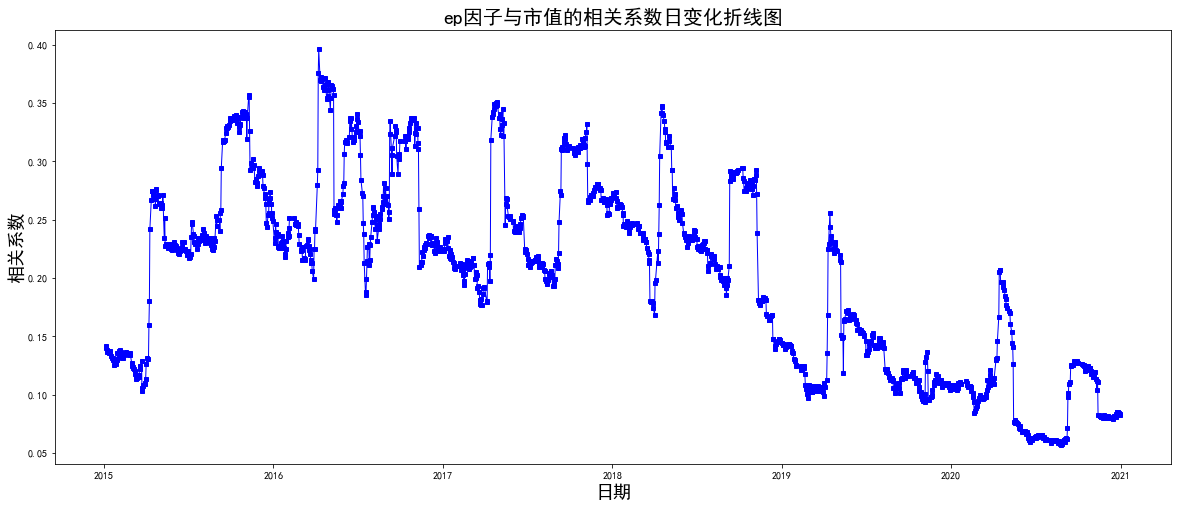

<Figure size 432x288 with 0 Axes>

In [61]:
####因子与市值的相关系数日变化折线图  2015-2020

plt.figure(figsize=(20,8))
x=corr_2['trade_date']
y=corr_2['corr']
plt.plot(x,y,lw=1,c='blue',marker='s',ms=4,label='ep因子与市值的日相关系数')
plt.title('ep因子与市值的相关系数日变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.15,0.05,0.05)
plt.xlabel('日期',fontsize=18)
plt.ylabel('相关系数',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('ep因子与市值的相关系数日变化折线图.png')

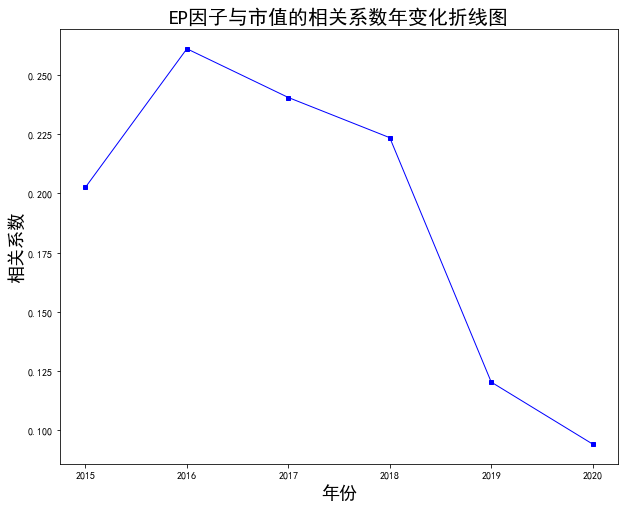

<Figure size 432x288 with 0 Axes>

In [62]:
####因子与市值的相关系数年变化折线图  2015-2020

plt.figure(figsize=(10,8))
x=corr_1['year']
y=corr_1['corr']
plt.plot(x,y,lw=1,c='blue',marker='s',ms=4,label='EP因子与市值的年相关系数')
plt.title('EP因子与市值的相关系数年变化折线图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('年份',fontsize=18)
plt.ylabel('相关系数',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('EP因子与市值的相关系数年变化折线图.png')

In [63]:
# 因子处理：去极值处理(winsorize, 0.03)以及中性化处理:先进行行业中性化(减行业均值)后在进行市值中性化（回归取残差），最后做标准化()

industry_factor=industry_factor[(industry_factor['trade_date']>'2014-12-31')&(industry_factor['trade_date']<'2021-01-01')]
industry_factor['win_EP']=winsorize(industry_factor.EP,limits=[0.03,0.03]) # 去极值处理(winsorize,0.03)

<ipython-input-63-149c38df34e1>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  industry_factor['win_EP']=winsorize(industry_factor.EP,limits=[0.03,0.03]) # 去极值处理(winsorize,0.03)


In [64]:
# 行业中性化（减行业均值）

neu_ind_1=pd.DataFrame(industry_factor.groupby(['trade_date','industry_name'])['win_EP'].mean())
neu_ind_1=neu_ind_1.rename(columns={'win_EP':'ind_mean'}).reset_index()
neu_ind_2=pd.merge(neu_ind_1,industry_factor,on=['trade_date','industry_name'],how='right')
neu_ind_2['ind_neu_EP']=neu_ind_2['win_EP']-neu_ind_2['ind_mean']

In [65]:
# 市值中性化（回归取残差）
# position=neu_ind_2.isnull().stack().index.tolist()

def lr_resid(sdf):
    lr=LinearRegression().fit(sdf[['firm_size']],sdf['ind_neu_EP'])
    return sdf['ind_neu_EP']-lr.predict(sdf[['firm_size']])

# %%time
neu_ind_2=neu_ind_2.dropna(subset=['ind_neu_EP','firm_size'])
neu_ind_2['fz_ind_neu_EP']=neu_ind_2.groupby("trade_date").apply(lr_resid).rename("fz_ind_neu_EP").reset_index(level=0)['fz_ind_neu_EP']


In [66]:
neu_ind_2

trade_date industry_name    ind_mean    ts_code industry_id  \
0       2015-01-05            银行  456.701708  000001.SZ      011018   
1       2015-01-06            银行  457.426563  000001.SZ      011018   
2       2015-01-07            银行  457.214943  000001.SZ      011018   
3       2015-01-08            银行  458.451329  000001.SZ      011018   
4       2015-01-09            银行  457.346353  000001.SZ      011018   
...            ...           ...         ...        ...         ...   
3978276 2020-12-25          医药生物   89.749396  688399.SH      011012   
3978277 2020-12-28          医药生物   89.735578  688399.SH      011012   
3978278 2020-12-29          医药生物   88.517685  688399.SH      011012   
3978279 2020-12-30          医药生物   87.827627  688399.SH      011012   
3978280 2020-12-31          医药生物   87.723158  688399.SH      011012   

                 EP   close   total_share  market_equity     firm_size  year  \
0        418.442675   16.02  1.142489e+06   1.830268e+07  1.830268e+07  2015   
1        427.383758   15.78  1.142489e+06   1.802848e+07  1.802848e+07  2015   
2        426.654434   15.48  1.142489e+06   1.768574e+07  1.768574e+07  2015   
3        436.715281   14.96  1.142489e+06   1.709164e+07  1.709164e+07  2015   
4        425.565103   15.08  1.142489e+06   1.722874e+07  1.722874e+07  2015   
...             ...     ...           ...            ...           ...   ...   
3978276  152.700444  195.95  5.862000e+03   1.148659e+06  1.148659e+06  2020   
3978277  153.166245  204.00  5.862000e+03   1.195848e+06  1.195848e+06  2020   
3978278  151.454131  191.92  5.862000e+03   1.125035e+06  1.125035e+06  2020   
3978279  152.156057  191.00  5.862000e+03   1.119642e+06  1.119642e+06  2020   
3978280  136.139630  192.34  5.862000e+03   1.127497e+06  1.127497e+06  2020   

             win_EP  ind_neu_EP  fz_ind_neu_EP  
0        418.442675  -38.259033     -58.078186  
1        427.383758  -30.042805     -49.434543  
2        426.654434  -30.560509     -49.550560  
3        436.715281  -21.736049     -40.919052  
4        425.565103  -31.781250     -50.752115  
...             ...         ...            ...  
3978276  152.700444   62.951048      63.834538  
3978277  153.166245   63.430667      64.240072  
3978278  151.454131   62.936446      63.810727  
3978279  152.156057   64.328430      65.203581  
3978280  136.139630   48.416472      49.294921  

[3978281 rows x 14 columns]

In [67]:
# 标准化：Z-score标准化，z=（个体观察值-当天总体数均值）/当天总体数据标准差

std_1=pd.DataFrame(neu_ind_2.groupby(['trade_date'])['fz_ind_neu_EP'].mean()).reset_index().rename(columns={'fz_ind_neu_EP':'date_mean'})
std_2=pd.DataFrame(neu_ind_2.groupby(['trade_date'])['fz_ind_neu_EP'].std()).reset_index().rename(columns={'fz_ind_neu_EP':'date_std'})
std_3=pd.merge(std_1,std_2,on=['trade_date'])
std_4=pd.merge(neu_ind_2,std_3,on=['trade_date'],how='left').sort_values(by=['trade_date','ts_code'])
std_4['std_neu_EP']=(std_4['fz_ind_neu_EP']-std_4['date_mean'])/std_4['date_std']

In [68]:
industry_factor

trade_date    ts_code industry_id industry_name          EP   close  \
1429    2015-01-05  000001.SZ      011018            银行  418.442675   16.02   
1430    2015-01-06  000001.SZ      011018            银行  427.383758   15.78   
1431    2015-01-07  000001.SZ      011018            银行  426.654434   15.48   
1432    2015-01-08  000001.SZ      011018            银行  436.715281   14.96   
1433    2015-01-09  000001.SZ      011018            银行  425.565103   15.08   
...            ...        ...         ...           ...         ...     ...   
7573048 2020-12-25  688399.SH      011012          医药生物  152.700444  195.95   
7573049 2020-12-28  688399.SH      011012          医药生物  153.166245  204.00   
7573050 2020-12-29  688399.SH      011012          医药生物  151.454131  191.92   
7573051 2020-12-30  688399.SH      011012          医药生物  152.156057  191.00   
7573052 2020-12-31  688399.SH      011012          医药生物  136.139630  192.34   

          total_share  market_equity     firm_size  year      win_EP  
1429     1.142489e+06   1.830268e+07  1.830268e+07  2015  418.442675  
1430     1.142489e+06   1.802848e+07  1.802848e+07  2015  427.383758  
1431     1.142489e+06   1.768574e+07  1.768574e+07  2015  426.654434  
1432     1.142489e+06   1.709164e+07  1.709164e+07  2015  436.715281  
1433     1.142489e+06   1.722874e+07  1.722874e+07  2015  425.565103  
...               ...            ...           ...   ...         ...  
7573048  5.862000e+03   1.148659e+06  1.148659e+06  2020  152.700444  
7573049  5.862000e+03   1.195848e+06  1.195848e+06  2020  153.166245  
7573050  5.862000e+03   1.125035e+06  1.125035e+06  2020  151.454131  
7573051  5.862000e+03   1.119642e+06  1.119642e+06  2020  152.156057  
7573052  5.862000e+03   1.127497e+06  1.127497e+06  2020  136.139630  

[3978281 rows x 11 columns]

In [69]:
# 整体结果做OLS回归，即因子值对下一个日期回报的进行回归

# 计算回报
ret_1=std_4.sort_values(by=['ts_code','trade_date']).drop_duplicates(subset=['ts_code','trade_date']).set_index(['trade_date','ts_code'])
ret_2=ret_1['close'].unstack()
ret_3=(ret_2.shift(-1)-ret_2)/ret_2
ret_4=ret_3.stack().reset_index().rename(columns={0:'ret_t1'})
ret_5=pd.merge(ret_4,std_4,on=['trade_date','ts_code'],how='right')
# ret = ret_5.pivot(index = 'trade_date',columns = 'ts_code',values = 'close').pct_change(1).shift(-1).fillna(0)

In [70]:
ret_5

trade_date    ts_code    ret_t1 industry_name    ind_mean industry_id  \
0       2015-01-05  000001.SZ -0.014981            银行  456.701708      011018   
1       2015-01-05  000002.SZ -0.036888           房地产  108.520199      011015   
2       2015-01-05  000004.SZ  0.049076          医药生物   51.922415      011012   
3       2015-01-05  000006.SZ -0.032486           房地产  108.520199      011015   
4       2015-01-05  000007.SZ -0.017218          休闲服务   94.743069      011017   
...            ...        ...       ...           ...         ...         ...   
3978276 2020-12-31  688366.SH       NaN          医药生物   87.723158      011012   
3978277 2020-12-31  688368.SH       NaN            电子   59.400080      011006   
3978278 2020-12-31  688369.SH       NaN           计算机   48.825853      011026   
3978279 2020-12-31  688389.SH       NaN          医药生物   87.723158      011012   
3978280 2020-12-31  688399.SH       NaN          医药生物   87.723158      011012   

                 EP   close   total_share  market_equity     firm_size  year  \
0        418.442675   16.02  1.142489e+06   1.830268e+07  1.830268e+07  2015   
1        249.296660   14.91  1.101503e+06   1.642341e+07  1.642341e+07  2015   
2         35.043689   15.69  8.397668e+03   1.317594e+05  1.317594e+05  2015   
3        126.772236    7.08  1.349995e+05   9.557965e+05  9.557965e+05  2015   
4        -26.765173   14.52  2.309654e+04   3.353617e+05  3.353617e+05  2015   
...             ...     ...           ...            ...           ...   ...   
3978276  169.892482   90.15  1.772066e+04   1.597517e+06  1.597517e+06  2020   
3978277   50.018733  172.09  6.160000e+03   1.060074e+06  1.060074e+06  2020   
3978278   73.963794   76.80  7.698958e+03   5.912800e+05  5.912800e+05  2020   
3978279   93.144702   21.00  4.222000e+04   8.866200e+05  8.866200e+05  2020   
3978280  136.139630  192.34  5.862000e+03   1.127497e+06  1.127497e+06  2020   

             win_EP  ind_neu_EP  fz_ind_neu_EP     date_mean    date_std  \
0        418.442675  -38.259033     -58.078186  3.534201e-16  106.358560   
1        249.296660  140.776462     123.229499  3.534201e-16  106.358560   
2         35.043689  -16.878726     -14.727819  3.534201e-16  106.358560   
3        126.772236   18.252038      19.406620  3.534201e-16  106.358560   
4        -26.765173 -121.508242    -119.603506  3.534201e-16  106.358560   
...             ...         ...            ...           ...         ...   
3978276  169.892482   82.169324      82.651263  8.673682e-15  111.261089   
3978277   50.018733   -9.381347      -8.446021  8.673682e-15  111.261089   
3978278   73.963794   25.137942      26.468743  8.673682e-15  111.261089   
3978279   93.144702    5.421544       6.503196  8.673682e-15  111.261089   
3978280  136.139630   48.416472      49.294921  8.673682e-15  111.261089   

         std_neu_EP  
0         -0.546060  
1          1.158623  
2         -0.138473  
3          0.182464  
4         -1.124531  
...             ...  
3978276    0.742859  
3978277   -0.075912  
3978278    0.237898  
3978279    0.058450  
3978280    0.443056  

[3978281 rows x 18 columns]

In [72]:
# 做回归

OLS=sm.ols(formula="ret_t1~std_neu_EP",data=ret_5).fit()
OLS.summary()


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 ret_t1   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                     3.949
Date:                Sun, 10 Apr 2022   Prob (F-statistic):             0.0469
Time:                        11:45:48   Log-Likelihood:             7.9652e+06
No. Observations:             3956616   AIC:                        -1.593e+07
Df Residuals:                 3956614   BIC:                        -1.593e+07
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0002   1.62e-05      9.316      0.000       0.000       0.000
std_neu_EP -3.229e-05   1.62e-05     -1.987      0.047   -6.41e-05   -4.41e-07
==============================================================================
Omnibus:                  1762076.669   Durbin-Watson:                   1.271
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        101976674.761
Skew:                          -1.353   Prob(JB):                         0.00
Kurtosis:                      27.723   Cond. No.                         1.00
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [76]:
# IC计算

# Normal IC
IC_1=pd.DataFrame(ret_5.groupby(['trade_date'])['std_neu_EP'].corr(ret_5['ret_t1'])).reset_index()
IC_1=IC_1.rename(columns={'std_neu_EP':'Normal_IC'})



In [77]:
IC_1

trade_date  Normal_IC
0    2015-01-05  -0.025862
1    2015-01-06  -0.028990
2    2015-01-07  -0.082815
3    2015-01-08   0.046885
4    2015-01-09   0.016567
...         ...        ...
1457 2020-12-25  -0.003127
1458 2020-12-28   0.011019
1459 2020-12-29  -0.008050
1460 2020-12-30  -0.004302
1461 2020-12-31        NaN

[1462 rows x 2 columns]

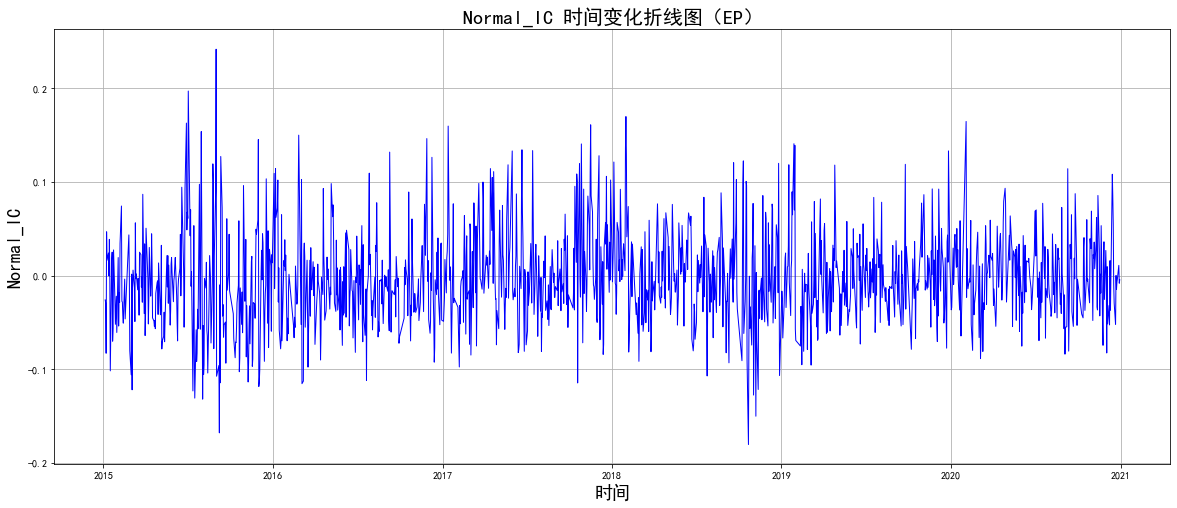

<Figure size 432x288 with 0 Axes>

In [78]:
# Normal IC 时间变化折线图

plt.figure(figsize=(20,8))
x=IC_1['trade_date']
y=IC_1['Normal_IC']
plt.plot(x,y,lw=1,c='blue',ms=4,label='Normal_IC 时间变化折线图')
plt.title('Normal_IC 时间变化折线图（EP）',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('Normal_IC',fontsize=18)
plt.grid()
plt.show()
plt.savefig('Normal_IC 时间变化折线图（EP）.png')



In [79]:
# rank IC 排序升序
IC_2=ret_5
IC_2['fac_rank']=IC_2.groupby(['trade_date'])['std_neu_EP'].rank()
IC_3=pd.DataFrame(IC_2.groupby(['trade_date'])['fac_rank'].corr(IC_2['ret_t1'])).reset_index()
IC_3=IC_3.rename(columns={'fac_rank':'rank_IC'})


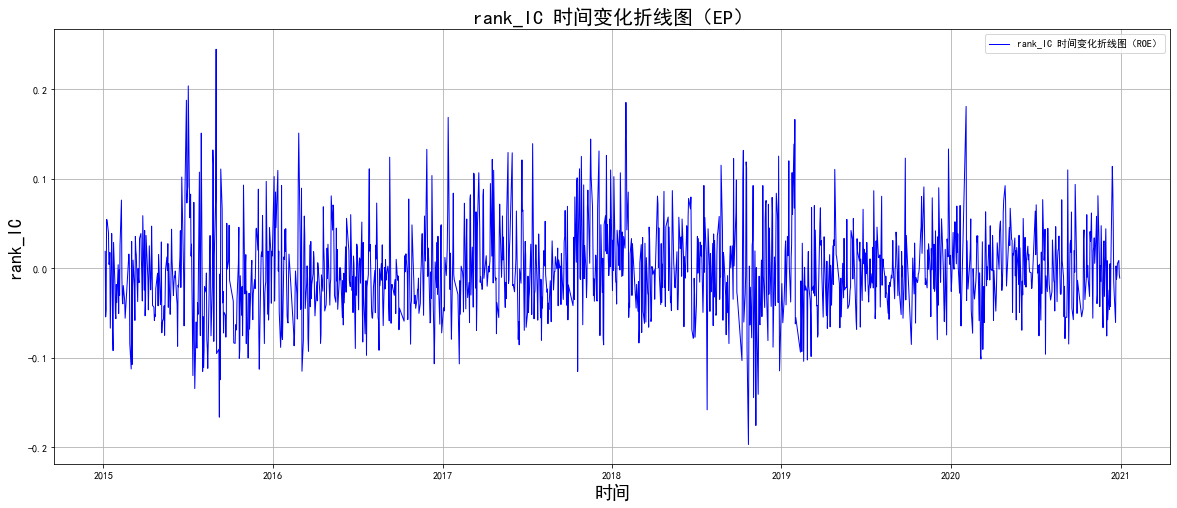

<Figure size 432x288 with 0 Axes>

In [80]:
# rank IC 时间变化折线图

plt.figure(figsize=(20,8))
x=IC_3['trade_date']
y=IC_3['rank_IC']
plt.plot(x,y,lw=1,c='blue',ms=4,label='rank_IC 时间变化折线图（ROE）')
plt.title('rank_IC 时间变化折线图（EP）',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('rank_IC',fontsize=18)
plt.legend()
plt.grid()
plt.show()
plt.savefig('rank_IC 时间变化折线图（EP）.png')



In [81]:
IC_4=pd.DataFrame()
Normal_IC=pd.Series({"mean":IC_1['Normal_IC'].mean(),"std":IC_1['Normal_IC'].std(),"IRIC":IC_1['Normal_IC'].mean()/IC_1['Normal_IC'].std(),"skew":IC_1['Normal_IC'].skew()},name="Normal_IC")
rank_IC=pd.Series({"mean":IC_3['rank_IC'].mean(),"std":IC_3['rank_IC'].std(),"IRIC":IC_3['rank_IC'].mean()/IC_3['rank_IC'].std(),"skew":IC_3['rank_IC'].skew()},name="rank_IC")
IC_4=IC_4.append(Normal_IC)
IC_4=IC_4.append(rank_IC)


In [82]:
IC_4

IRIC      mean      skew       std
Normal_IC -0.062772 -0.003131  0.514257  0.049884
rank_IC   -0.054092 -0.002767  0.477726  0.051156

In [83]:
# 分层测试
Group_test=ret_5.copy()
Group_test['Group_ID']=Group_test.groupby(['trade_date'])['std_neu_EP'].transform(lambda x:pd.qcut(x,[0,0.2,0.4,0.6,0.8,1],labels=['1','2','3','4','5']))
Group_test_1=pd.DataFrame(Group_test.groupby(['trade_date','Group_ID'])['ret_t1'].mean()).reset_index().rename(columns={'ret_t1':'Group_ret_mean'})


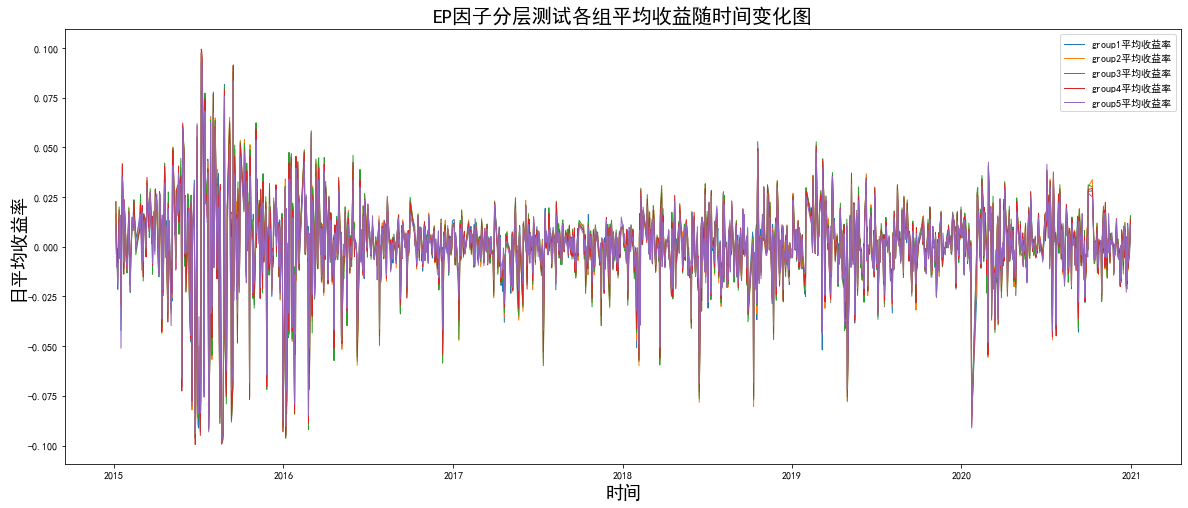

<Figure size 432x288 with 0 Axes>

In [84]:
# 因子分层测试各组日平均收益随时间变化图

x=pd.Series(np.unique(Group_test_1['trade_date']))
y1=Group_test_1[Group_test_1['Group_ID']=='1']['Group_ret_mean']
y2=Group_test_1[Group_test_1['Group_ID']=='2']['Group_ret_mean']
y3=Group_test_1[Group_test_1['Group_ID']=='3']['Group_ret_mean']
y4=Group_test_1[Group_test_1['Group_ID']=='4']['Group_ret_mean']
y5=Group_test_1[Group_test_1['Group_ID']=='5']['Group_ret_mean']

plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='group1平均收益率')
plt.plot(x,y2,lw=1,ms=4,label='group2平均收益率')
plt.plot(x,y3,lw=1,ms=4,label='group3平均收益率')
plt.plot(x,y4,lw=1,ms=4,label='group4平均收益率')
plt.plot(x,y5,lw=1,ms=4,label='group5平均收益率')
plt.title('EP因子分层测试各组平均收益随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('日平均收益率',fontsize=18)
plt.legend()
# plt.grid()
plt.show()
plt.savefig('EP因子分层测试各组平均收益随时间变化图.png')

In [85]:
# 计算各组累计收益率

Group_test_1['cum_rev'] =Group_test_1.sort_values(by=['Group_ID','trade_date']).groupby(['Group_ID'])['Group_ret_mean'].apply(lambda x:(1 + x).cumprod())

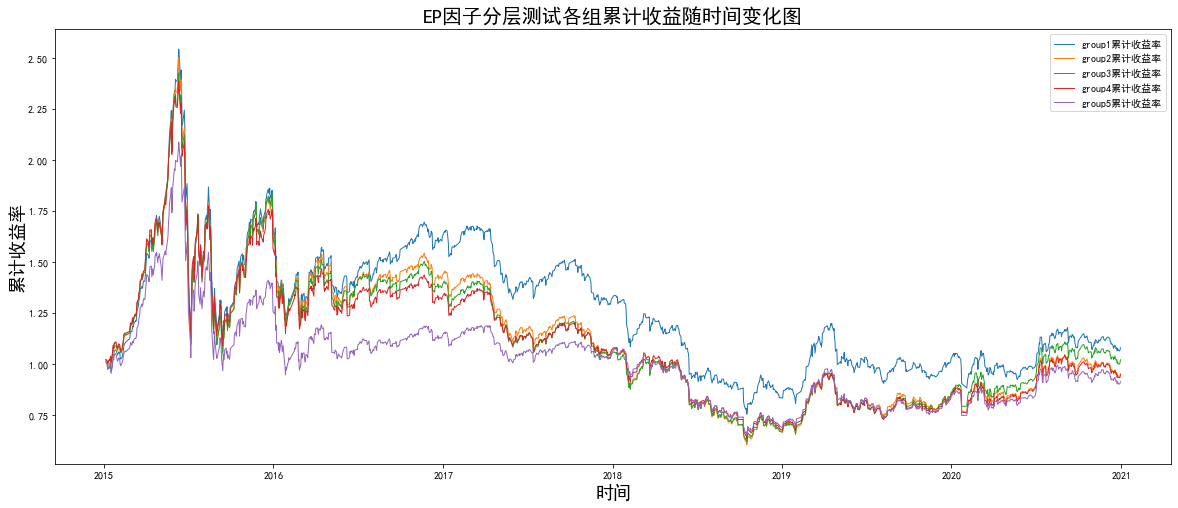

<Figure size 432x288 with 0 Axes>

In [86]:
# 因子分层测试各组累计收益随时间变化图

x=pd.Series(np.unique(Group_test_1['trade_date']))
y1=Group_test_1[Group_test_1['Group_ID']=='1']['cum_rev']
y2=Group_test_1[Group_test_1['Group_ID']=='2']['cum_rev']
y3=Group_test_1[Group_test_1['Group_ID']=='3']['cum_rev']
y4=Group_test_1[Group_test_1['Group_ID']=='4']['cum_rev']
y5=Group_test_1[Group_test_1['Group_ID']=='5']['cum_rev']

plt.figure(figsize=(20,8))
plt.plot(x,y1,lw=1,ms=4,label='group1累计收益率')
plt.plot(x,y2,lw=1,ms=4,label='group2累计收益率')
plt.plot(x,y3,lw=1,ms=4,label='group3累计收益率')
plt.plot(x,y4,lw=1,ms=4,label='group4累计收益率')
plt.plot(x,y5,lw=1,ms=4,label='group5累计收益率')
plt.title('EP因子分层测试各组累计收益随时间变化图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('时间',fontsize=18)
plt.ylabel('累计收益率',fontsize=18)
plt.legend()
# plt.grid()
plt.show()
plt.savefig('EP因子分层测试各组累计收益随时间变化图.png')

In [87]:
# 计算各组年化收益率&年化波动率&夏普比率&最大回撤


Annual_1=pd.DataFrame(Group_test_1.groupby(['Group_ID'])['Group_ret_mean'].mean()).reset_index().rename(columns={'Group_ret_mean':'aver_ret'})
Annual_2=pd.DataFrame(Group_test_1.groupby(['Group_ID'])['Group_ret_mean'].var()).reset_index().rename(columns={'Group_ret_mean':'volatility'})
Annual_3=pd.merge(Annual_1,Annual_2,on=['Group_ID'])
Annual_3['Annual_aver_ret']=(1+Annual_3['aver_ret'])**252-1
Annual_3['Annual_vol']=((Annual_3['volatility'])*252)**0.5
Annual_3['Annual_Sharpe']=252*Annual_3['aver_ret']/Annual_3['Annual_vol']

arr_1=Group_test_1[Group_test_1['Group_ID']=='1']['cum_rev']
j_1 = np.argmax((np.maximum.accumulate(arr_1) - arr_1)/np.maximum.accumulate(arr_1)) # end of the period
i_1 = np.argmax(arr_1[:j_1]) # start of period
MaxDrawdown_1=(1-arr_1.iloc[j_1]/arr_1.iloc[i_1])

arr_2=Group_test_1[Group_test_1['Group_ID']=='2']['cum_rev']
j_2 = np.argmax((np.maximum.accumulate(arr_2) - arr_2)/np.maximum.accumulate(arr_2)) # end of the period
i_2 = np.argmax(arr_2[:j_2]) # start of period
MaxDrawdown_2=(1-arr_2.iloc[j_2]/arr_2.iloc[i_2])


arr_3=Group_test_1[Group_test_1['Group_ID']=='3']['cum_rev']
j_3 = np.argmax((np.maximum.accumulate(arr_3) - arr_3)/np.maximum.accumulate(arr_3)) # end of the period
i_3 = np.argmax(arr_3[:j_3]) # start of period
MaxDrawdown_3=(1-arr_3.iloc[j_3]/arr_3.iloc[i_3])


arr_4=Group_test_1[Group_test_1['Group_ID']=='4']['cum_rev']
j_4 = np.argmax((np.maximum.accumulate(arr_4) - arr_4)/np.maximum.accumulate(arr_4)) # end of the period
i_4 = np.argmax(arr_4[:j_4]) # start of period
MaxDrawdown_4=(1-arr_4.iloc[j_4]/arr_4.iloc[i_4])


arr_5=Group_test_1[Group_test_1['Group_ID']=='5']['cum_rev']
j_5 = np.argmax((np.maximum.accumulate(arr_5) - arr_5)/np.maximum.accumulate(arr_5)) # end of the period
i_5 = np.argmax(arr_5[:j_5]) # start of period
MaxDrawdown_5=(1-arr_5.iloc[j_5]/arr_5.iloc[i_5])




Annual_4=pd.DataFrame()
Annual_aver_ret=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_aver_ret']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_aver_ret']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_aver_ret']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_aver_ret']),"Group5":float(Annual_3[Annual_3['Group_ID']=='5']['Annual_aver_ret'])},name="Annual_average_return")
Annual_vol=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_vol']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_vol']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_vol']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_vol']),"Group5":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_vol'])},name="Annual_volatility")
Annual_sharpe=pd.Series({"Group1":float(Annual_3[Annual_3['Group_ID']=='1']['Annual_Sharpe']),"Group2":float(Annual_3[Annual_3['Group_ID']=='2']['Annual_Sharpe']),"Group3":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_Sharpe']),"Group4":float(Annual_3[Annual_3['Group_ID']=='4']['Annual_Sharpe']),"Group5":float(Annual_3[Annual_3['Group_ID']=='3']['Annual_Sharpe'])},name="Annual_Sharpe_Ratio")
Annual_MaxDrawdown=pd.Series({"Group1":MaxDrawdown_1,"Group2":MaxDrawdown_2,"Group3":MaxDrawdown_3,"Group4":MaxDrawdown_4,"Group5":MaxDrawdown_5},name="Annual_MaxDrawdown")


Annual_4=Annual_4.append(Annual_aver_ret)
Annual_4=Annual_4.append(Annual_vol)
Annual_4=Annual_4.append(Annual_sharpe)
Annual_4=Annual_4.append(Annual_MaxDrawdown)

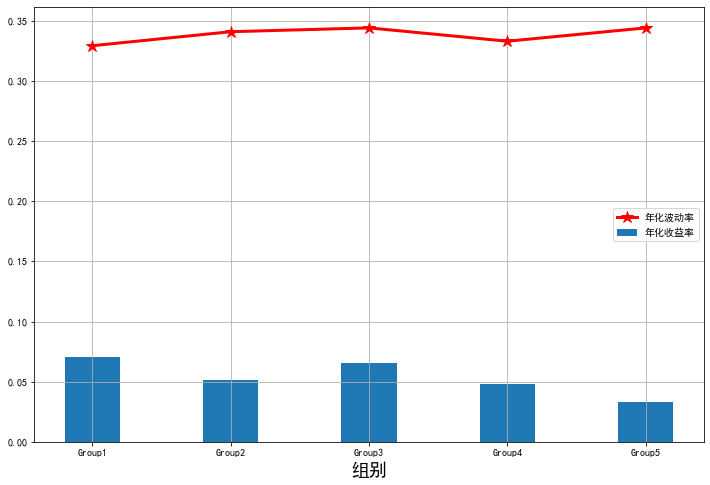

<Figure size 432x288 with 0 Axes>

In [88]:
# 年化数据组合图：年化收益&年化波动率
Annual_5=Annual_4.T.reset_index()
x=Annual_5['index']
y1=Annual_5['Annual_average_return']
y2=Annual_5['Annual_volatility']
# y3=Annual_5['Annual_Sharpe_Ratio']
# y4=Annual_5['Annual_MaxDrawdown']


plt.figure(figsize=(12,8))
plt.bar(x,y1,width=0.4,label='年化收益率')
plt.plot(x,y2,lw=3,ms=13,color='red',marker='*',label='年化波动率')
# plt.plot(x,y3,lw=3,ms=13,marker='^',label='年化夏普比')
# plt.plot(x,y4,lw=3,ms=13,marker='x',label='最大回撤率')

# for a,b in zip(x,y2):
#     plt.text(a,b,b,ha='center',va='bottom',fontsize=20)
# plt.title('年化数据组合图：年化收益&年化波动率',fontsize=20,fontweight='heavy',verticalalignment='baseline')

# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('组别',fontsize=18)
# plt.ylabel('累计收益率',fontsize=18)
plt.legend()
plt.grid()
plt.show()
plt.savefig('EP年化数据组合图：年化收益&年化波动率.png')

In [140]:
Annual_5

index  Annual_average_return  Annual_volatility  Annual_Sharpe_Ratio  \
0  Group1               0.070653           0.329101             0.207469   
1  Group2               0.051699           0.340699             0.147966   
2  Group3               0.065632           0.343891             0.184873   
3  Group4               0.048173           0.332815             0.141378   
4  Group5               0.033523           0.343891             0.184873   

   Annual_MaxDrawdown  
0            0.703077  
1            0.757675  
2            0.745216  
3            0.733201  
4            0.689072

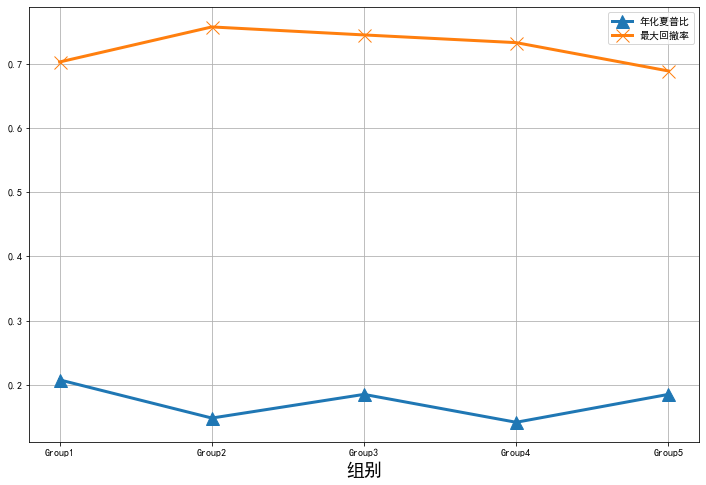

<Figure size 432x288 with 0 Axes>

In [89]:
# 年化数据组合图：最大回撤&年化夏普
Annual_5=Annual_4.T.reset_index()
x=Annual_5['index']
y3=Annual_5['Annual_Sharpe_Ratio']
y4=Annual_5['Annual_MaxDrawdown']


plt.figure(figsize=(12,8))
plt.plot(x,y3,lw=3,ms=13,marker='^',label='年化夏普比')
plt.plot(x,y4,lw=3,ms=13,marker='x',label='最大回撤率')

# for a,b in zip(x,y2):
#     plt.text(a,b,b,ha='center',va='bottom',fontsize=20)
# plt.title('年化数据组合图：年化收益&年化波动率',fontsize=20,fontweight='heavy',verticalalignment='baseline')

# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(-0.1,-0.02,0.005)
plt.xlabel('组别',fontsize=18)
# plt.ylabel('累计收益率',fontsize=18)
plt.legend()
plt.grid()
plt.show()
plt.savefig('EP年化数据组合图：最大回撤&年化夏普.png')

In [90]:
#各行业group1的年化收益

Ind_Group_test=Group_test[Group_test['Group_ID']=='1']
Ind_Group_test_1=pd.DataFrame(Ind_Group_test.groupby(['industry_name'])['ret_t1'].mean()).reset_index().rename(columns={'ret_t1':'ind_aver_ret'})
Ind_Group_test_1['Annual_ret']=(1+Ind_Group_test_1['ind_aver_ret'])**252-1

In [91]:
Ind_Group_test_1

industry_name  ind_aver_ret  Annual_ret
0           交通运输      0.000070    0.017752
1           休闲服务     -0.000149   -0.036865
2             传媒     -0.000589   -0.137870
3           公用事业     -0.000217   -0.053329
4           农林牧渔      0.000184    0.047565
5             化工      0.000394    0.104489
6           医药生物      0.000270    0.070326
7           商业贸易      0.000176    0.045319
8           国防军工      0.001074    0.310527
9           家用电器     -0.000510   -0.120731
10          建筑材料      0.000591    0.160458
11          建筑装饰     -0.000056   -0.013924
12           房地产      0.000310    0.081209
13          有色金属      0.000229    0.059442
14          机械设备      0.000344    0.090554
15            汽车      0.000301    0.078716
16            电子      0.000706    0.194741
17          电气设备      0.000468    0.125202
18          纺织服装     -0.000096   -0.023971
19            综合     -0.000103   -0.025632
20           计算机      0.000493    0.132241
21          轻工制造     -0.000338   -0.081614
22            通信      0.000801    0.223657
23            采掘      0.000326    0.085514
24            钢铁      0.000480    0.128475
25            银行      0.000044    0.011094
26          非银金融     -0.000369   -0.088714
27          食品饮料      0.000257    0.066994

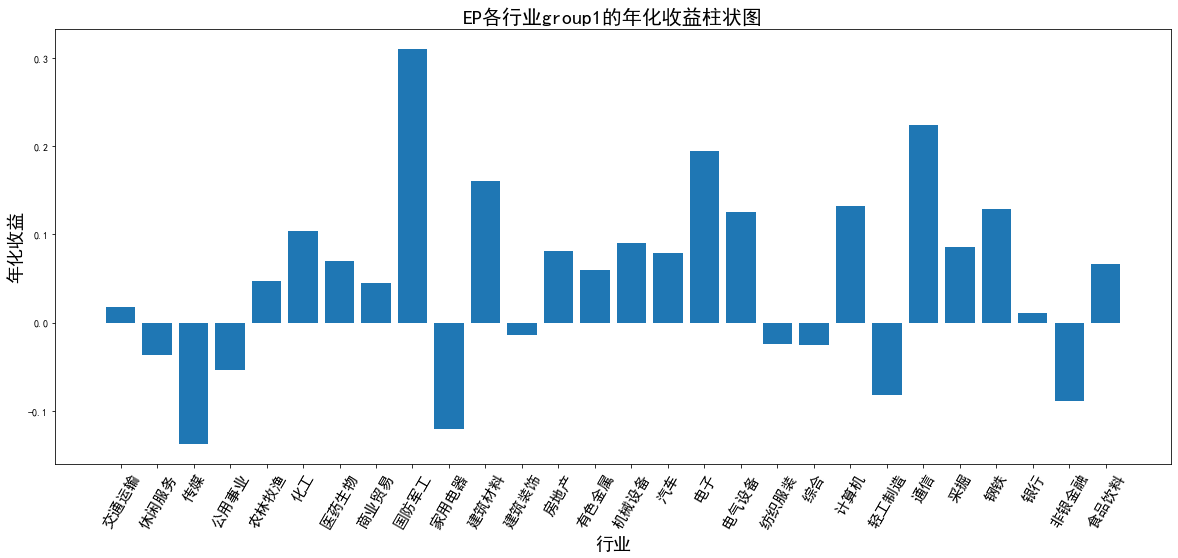

<Figure size 432x288 with 0 Axes>

In [92]:
####各行业group1的年化收益 

plt.figure(figsize=(20,8))
x=Ind_Group_test_1['industry_name']
y=Ind_Group_test_1['Annual_ret']
plt.bar(x,y)
plt.title('EP各行业group1的年化收益柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
# plt.ylim(0,6,1)
plt.xlabel('行业',fontsize=18)
plt.ylabel('年化收益',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('EP各行业group1的年化收益柱状图.png')

In [121]:
# 各个组别的换手率测试

Turnover_test_1=Group_test[Group_test['Group_ID']=='1']
turnover_1 = pd.DataFrame()
turnover_1['trade_date']= Turnover_test_1.trade_date.unique()
turnover_1['turnover'] = 0
    
for i in range(1,turnover_1.shape[0]):
    stock_now = set(Turnover_test_1.loc[Turnover_test_1.trade_date==turnover_1.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_1.loc[Turnover_test_1.trade_date==turnover_1.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_1.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


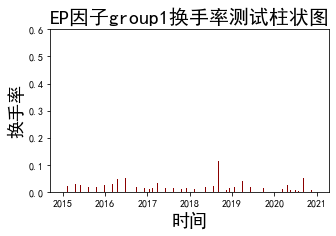

<Figure size 432x288 with 0 Axes>

In [131]:
####group1换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_1['trade_date']
y=turnover_1['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('EP因子group1换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.6,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('EP因子group1换手率测试柱状图.png')

In [123]:
# 各个组别的换手率测试

Turnover_test_2=Group_test[Group_test['Group_ID']=='2']
turnover_2 = pd.DataFrame()
turnover_2['trade_date']= Turnover_test_2.trade_date.unique()
turnover_2['turnover'] = 0
    
for i in range(1,turnover_2.shape[0]):
    stock_now = set(Turnover_test_2.loc[Turnover_test_2.trade_date==turnover_2.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_2.loc[Turnover_test_2.trade_date==turnover_2.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_2.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


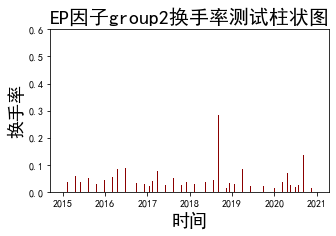

<Figure size 432x288 with 0 Axes>

In [132]:
####group2换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_2['trade_date']
y=turnover_2['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('EP因子group2换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.6,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('EP因子group2换手率测试柱状图.png')

In [125]:
# 各个组别的换手率测试

Turnover_test_3=Group_test[Group_test['Group_ID']=='3']
turnover_3 = pd.DataFrame()
turnover_3['trade_date']= Turnover_test_3.trade_date.unique()
turnover_3['turnover'] = 0
    
for i in range(1,turnover_3.shape[0]):
    stock_now = set(Turnover_test_3.loc[Turnover_test_3.trade_date==turnover_3.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_3.loc[Turnover_test_3.trade_date==turnover_3.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_3.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


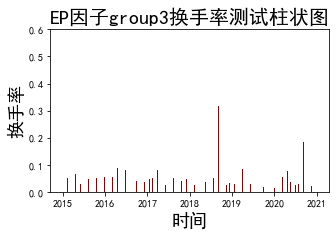

<Figure size 432x288 with 0 Axes>

In [133]:
####group3换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_3['trade_date']
y=turnover_3['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('EP因子group3换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.6,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('EP因子group3换手率测试柱状图.png')

In [127]:
# 各个组别的换手率测试

Turnover_test_4=Group_test[Group_test['Group_ID']=='4']
turnover_4 = pd.DataFrame()
turnover_4['trade_date']= Turnover_test_4.trade_date.unique()
turnover_4['turnover'] = 0
    
for i in range(1,turnover_4.shape[0]):
    stock_now = set(Turnover_test_4.loc[Turnover_test_4.trade_date==turnover_4.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_4.loc[Turnover_test_4.trade_date==turnover_4.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_4.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


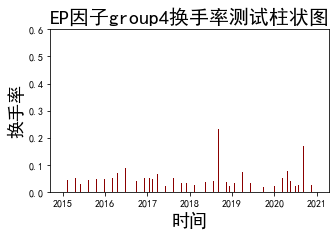

<Figure size 432x288 with 0 Axes>

In [134]:
####group4换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_4['trade_date']
y=turnover_4['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('EP因子group4换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.6,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('EP因子group4换手率测试柱状图.png')

In [129]:
# 各个组别的换手率测试

Turnover_test_5=Group_test[Group_test['Group_ID']=='5']
turnover_5 = pd.DataFrame()
turnover_5['trade_date']= Turnover_test_5.trade_date.unique()
turnover_5['turnover'] = 0
    
for i in range(1,turnover_5.shape[0]):
    stock_now = set(Turnover_test_5.loc[Turnover_test_5.trade_date==turnover_5.trade_date.iloc[i],'ts_code'].tolist())
    stock_pre = set(Turnover_test_5.loc[Turnover_test_5.trade_date==turnover_5.trade_date.iloc[i - 1],'ts_code'].tolist())
    turnover_5.loc[i,'turnover'] = len(stock_pre.difference(stock_now))/len(stock_pre)       
    


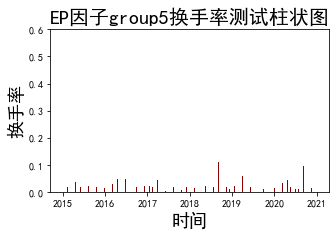

<Figure size 432x288 with 0 Axes>

In [135]:
####group5换手率测试柱状图

plt.figure(figsize=(5,3))
x=turnover_5['trade_date']
y=turnover_5['turnover']
plt.bar(x,y,color = 'darkred',width = 0.2)
plt.title('EP因子group5换手率测试柱状图',fontsize=20,fontweight='heavy',verticalalignment='baseline')
# plt.xticks(x,rotation=60,fontsize=15)
# plt.yticks(y,fontsize=15)
plt.ylim(0,0.6,0.05)
plt.xlabel('时间',fontsize=18)
plt.ylabel('换手率',fontsize=18)
# plt.grid()
plt.show()
plt.savefig('EP因子group5换手率测试柱状图.png')

Dropped 1.8% entries from factor data: 1.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Dropped 1.8% entries from factor data: 1.8% in forward returns computation and 0.0% in binning phase (set max_loss=0 to see potentially suppressed Exceptions).
max_loss is 100.0%, not exceeded: OK!
Returns Analysis


1D     5D    10D    20D
Ann. alpha                                    -0.015 -0.018 -0.020 -0.019
beta                                          -0.033 -0.059 -0.065 -0.071
Mean Period Wise Return Top Quantile (bps)    -0.802 -0.892 -0.962 -0.873
Mean Period Wise Return Bottom Quantile (bps)  0.659  1.060  1.137  1.177
Mean Period Wise Spread (bps)                 -1.461 -1.976 -2.125 -2.080

<Figure size 432x288 with 0 Axes>

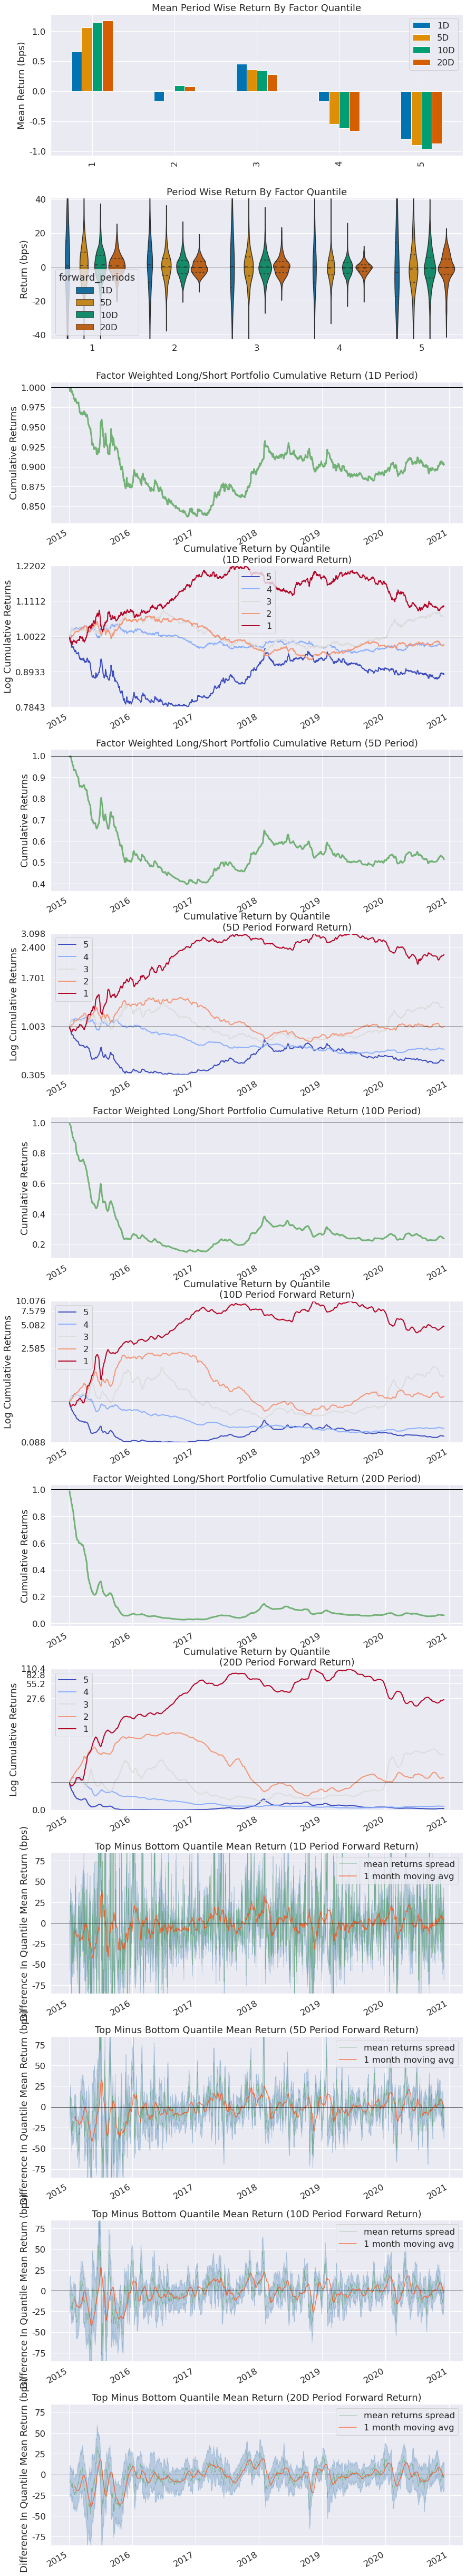

Information Analysis


1D     5D    10D    20D
IC Mean           0.007  0.008  0.008  0.009
IC Std.           0.061  0.072  0.076  0.079
Risk-Adjusted IC  0.112  0.115  0.108  0.115
t-stat(IC)        4.255  4.352  4.092  4.375
p-value(IC)       0.000  0.000  0.000  0.000
IC Skew           0.289  0.114  0.099 -0.078
IC Kurtosis       0.508 -0.103 -0.301 -0.341

/usr/lib/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/lib/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplo

<Figure size 432x288 with 0 Axes>

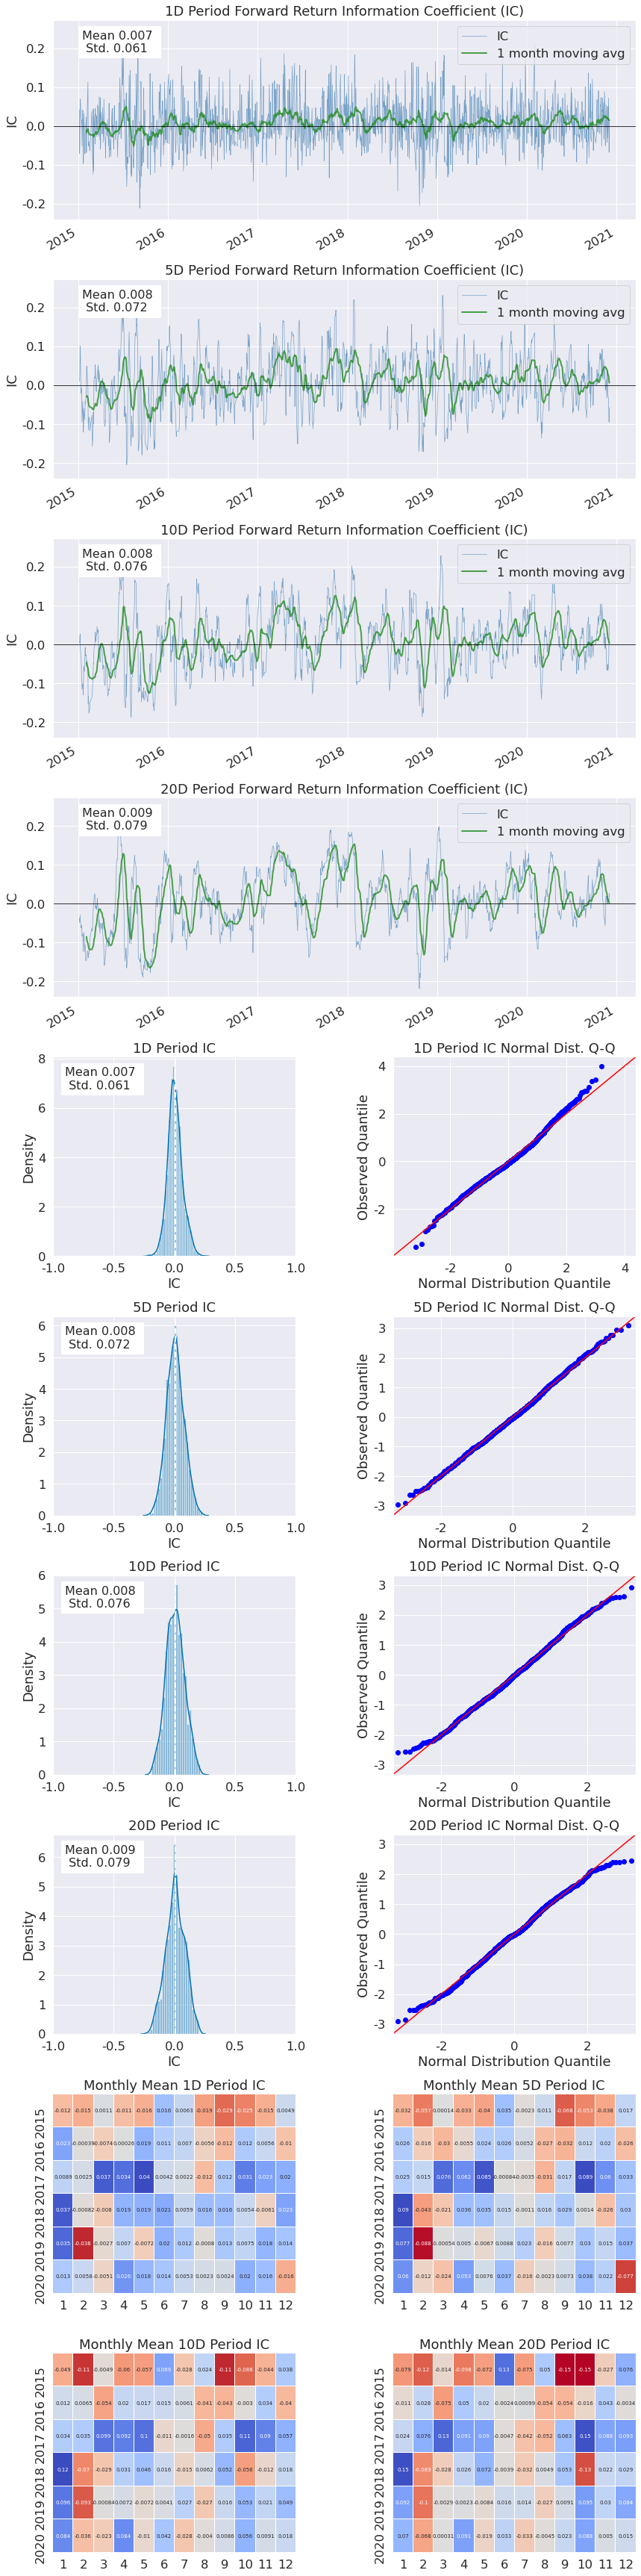

/usr/lib/miniconda3/lib/python3.8/site-packages/alphalens/utils.py:910: UserWarning: Skipping return periods that aren't exact multiples of days.
  warnings.warn(


Turnover Analysis


1D     5D    10D    20D
Quantile 1 Mean Turnover   0.027  0.086  0.134  0.207
Quantile 2 Mean Turnover   0.054  0.156  0.234  0.342
Quantile 3 Mean Turnover   0.066  0.190  0.282  0.399
Quantile 4 Mean Turnover   0.062  0.187  0.283  0.405
Quantile 5 Mean Turnover   0.034  0.112  0.177  0.266

1D     5D    10D    20D
Mean Factor Rank Autocorrelation  0.991  0.959  0.927  0.871

<Figure size 432x288 with 0 Axes>

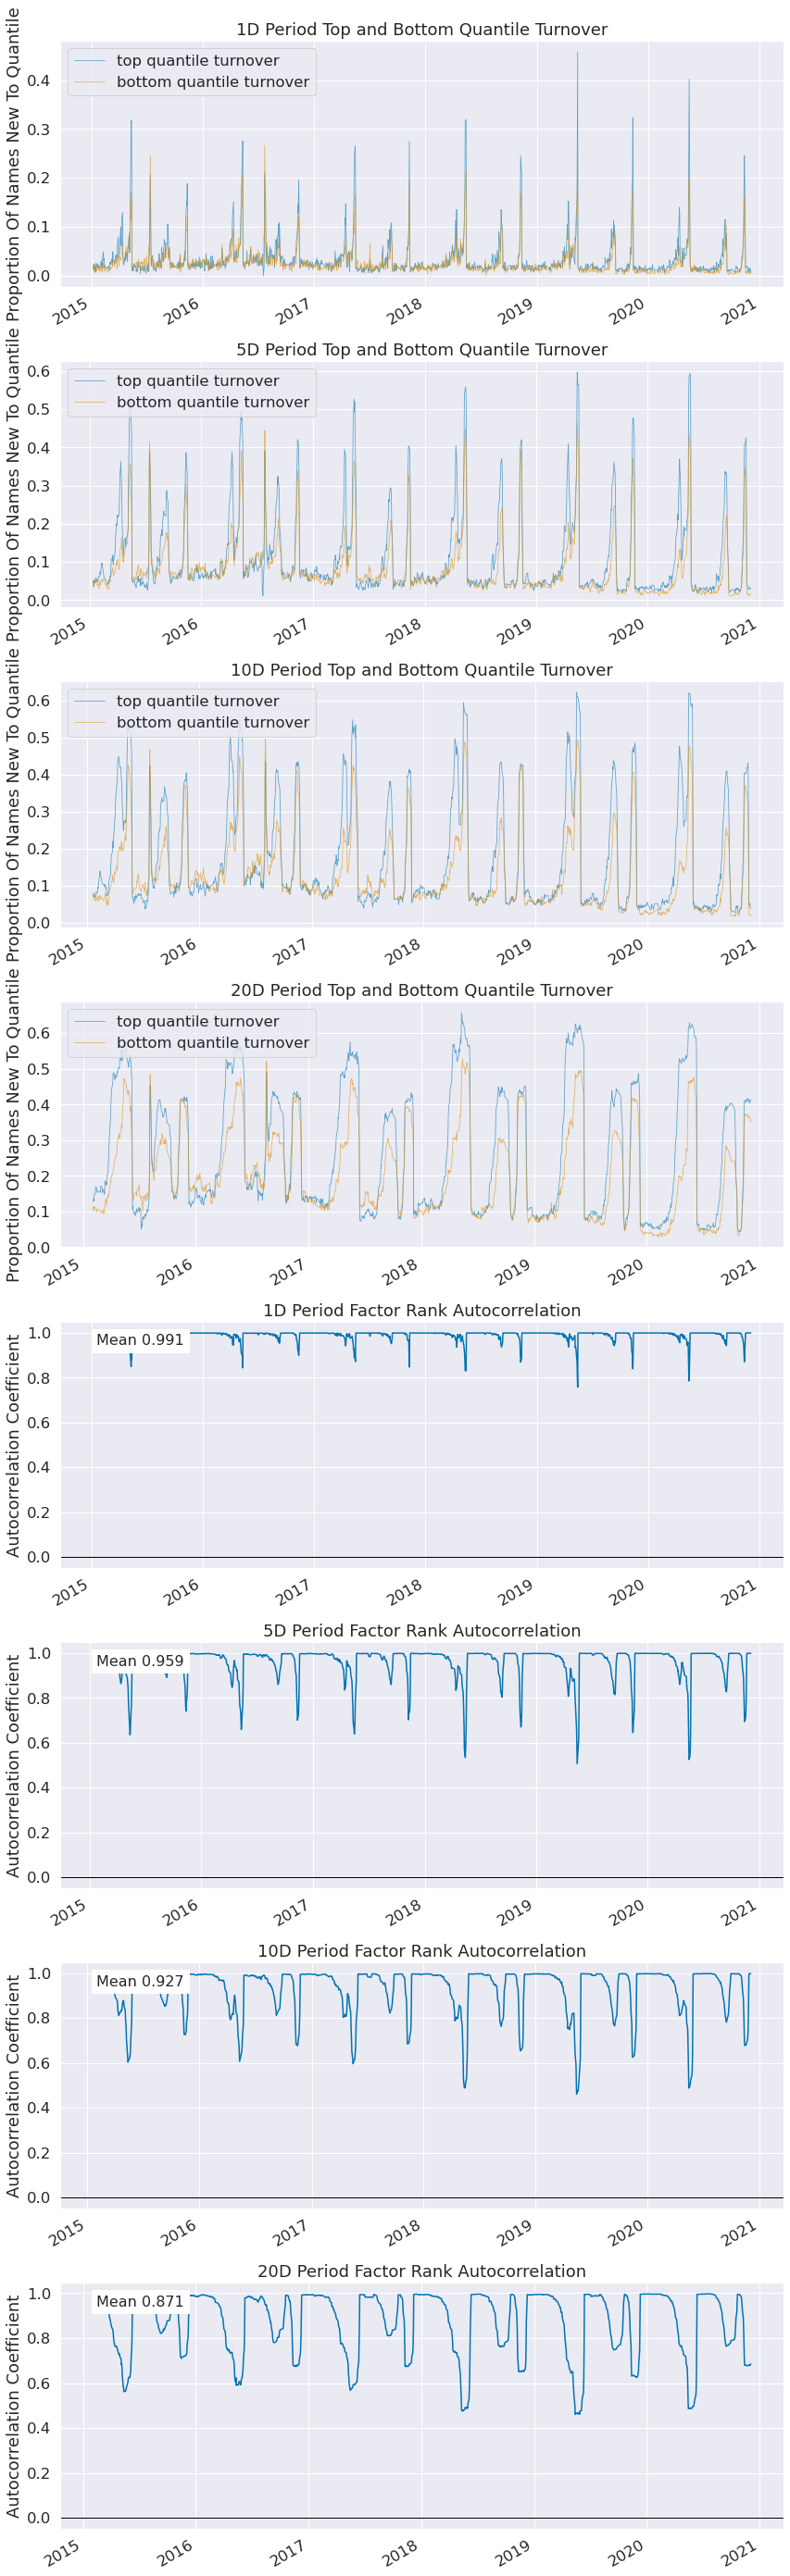

In [119]:
# Alphalens 回测结果

final=ret_5.set_index(["trade_date","ts_code"])
factor_init = final["std_neu_EP"].copy()
price_df = final["close"].unstack().copy()
factor = al.utils.get_clean_factor_and_forward_returns(factor_init, price_df,quantiles=5, bins=None,periods=(1,5,10,20),max_loss=1)


factor = al.utils.get_clean_factor_and_forward_returns(factor_init, price_df,groupby=None,binning_by_group=False,quantiles=5,bins=None,periods=(1,5,10,20),filter_zscore=20,groupby_labels=None,max_loss=1,zero_aware=False,cumulative_returns=True)
al.tears.create_returns_tear_sheet(factor)
al.tears.create_information_tear_sheet(factor, group_neutral=False,by_group=False)
al.tears.create_turnover_tear_sheet(factor, turnover_periods=None)
